# Project specification


## 1) Calibration (camera matrix, distortion coefficients)

## Pipeline
* 2) Color transform, Gradients -> thresholded binary image
* 3) Perspective transform
* 4) Identification of lane line pixels
* 5) Radius of curvature calculation
* 6) Lane area plotted back down onto the road

* (7) Lane history + smoothing)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from help_func import plot, draw_lines_from_points
import pickle
from collections import deque
# for interactive plots
# %matplotlib notebook
%matplotlib inline

# Camera calibration

Criteria:  
Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

Camera calibration requires both object points (x,y,z) and image points (x,y) of the calibration patterns.  
Since the chessboard pattern is assumed to be fixed at the (x,y) plane at z=0, the object points for all 9x6 calibration images are (0,0,0), (1,0,0), ... (8,5,0).  
The image points are determinded by the cv2.findChessboardCorners(), which outputs the 2D-coordinates of all chessboard corners from the input image.  

The function cv2.calibrateCamera() computes the camera matrix and distortion coefficients by using object and image points. Since the use of more than 10 calibration images is recommended ([openCV documentation](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html)), all of the provided 20 images are used. The respective object and image points of the images are simply appended and then passed to the calibration function. 

Distorted images can now be corrected by using the cv2.undistort() function, which takes the calibration matrix and distortion coefficients as input arguments. An example of an undistorted calibration image is provided below.

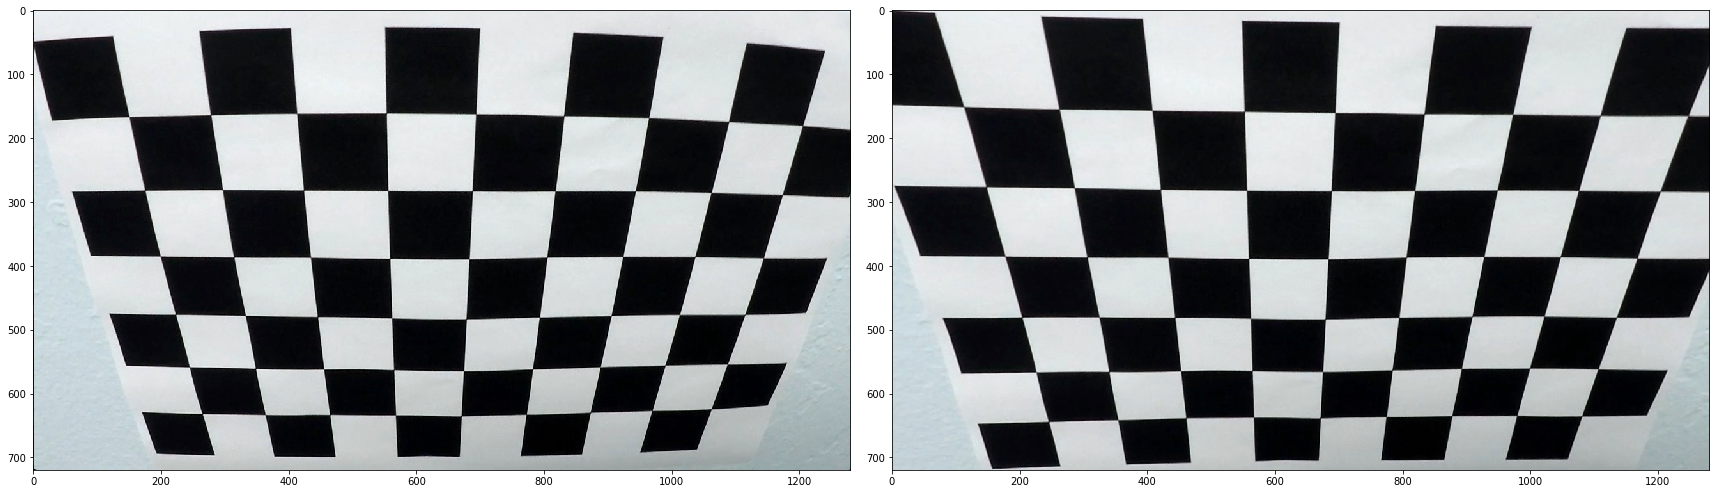

In [2]:
# initialize array for object points with dimensions (6*9, 3)
objp = np.zeros((6*9,3), np.float32)
# create mesh grid, transpose and reshape to get an (6*9, 2) array 
# for all object points (z component is assumed to be 0)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# initialize arrays for object- and image points from all calibration images
objpts = [] # 3D points in real world space
imgpts = [] # 2D points in image plane

# get list of all available calibration images
cal_images = glob.glob('camera_cal/calibration*.jpg')

# find chessboard corners in all images
for idx, img_name in enumerate(cal_images):
    img = cv2.imread(img_name) # read image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
    
    # find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    
    # if corners were found, object- and image points are added
    if ret == True:
        objpts.append(objp)
        imgpts.append(corners)

        # draw and display/save corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)        
        # folder_name = 'output_images/'
       # file_name = 'chessboard_corners_'+img_name[11:]
       # cv2.imwrite(folder_name+file_name, img)
#         plt.figure()
#         plt.imshow(img)
#         cv2.waitKey(500)

dist_img = cv2.imread('camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist_coeff, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, img_size, None ,None)

undist_img = cv2.undistort(dist_img, mtx, dist_coeff, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(dist_img)
ax2.imshow(undist_img)

# plt.imshow(undist_img)
# cv2.imwrite('output_images/calibration2_undistorted.jpg', undist)

# Pipeline (test images)

#### Criteria: Provide an example of a distortion-corrected image.

Now that the calibration matrix and distortion coefficients are available after the use of cv2.calibrateCamera(), every image taken with the same camera can be undistorted. The function cv2.undistort() is used for this task again. The results are shown below.

In [3]:
def undistort(dist_img):
    undist_img = cv2.undistort(dist_img, mtx, dist_coeff, None, mtx)
    return undist_img

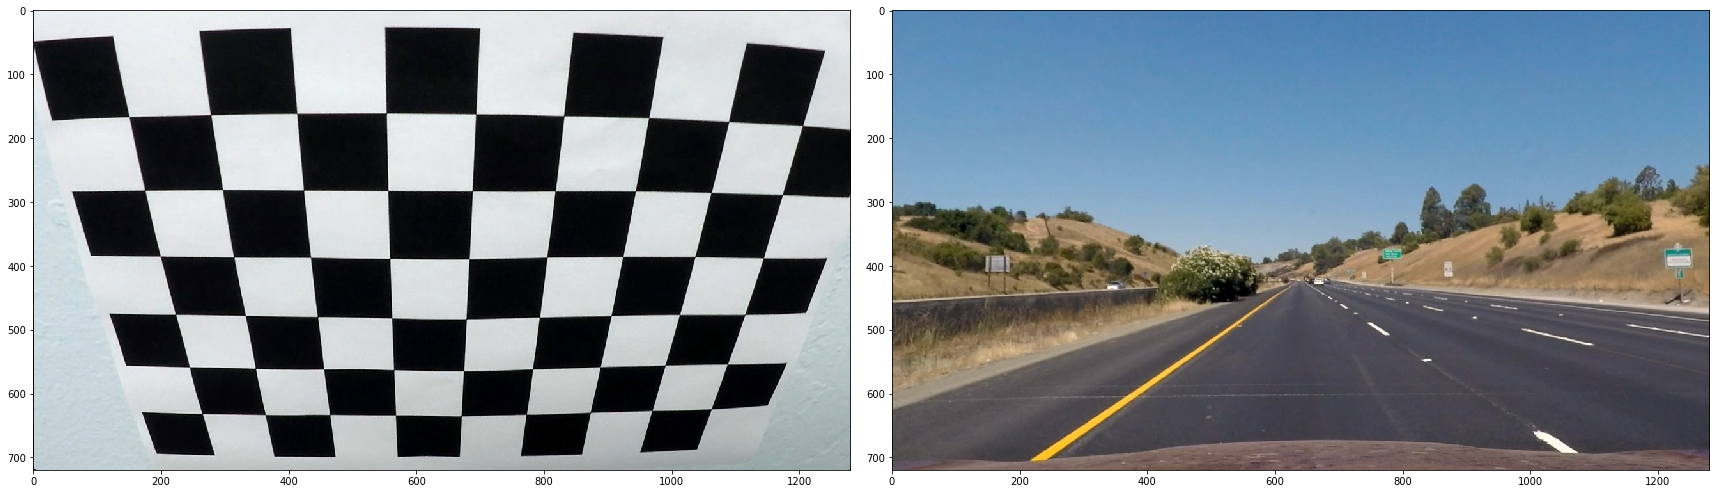

In [4]:
src_img = mpimg.imread('test_images/straight_lines1.jpg')
img_size = (img.shape[1], img.shape[0])

undist_img = undistort(src_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(dist_img)
ax2.imshow(undist_img)

#### Criteria: Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

A perspective transform requires a transformation matrix which can be computed by using the cv2.getPerspectiveTransform() function. This function takes 4 source points and 4 destination points as an input and outputs the transformation matrix. The choice of points is shown in the image below.
Since the lane lines on the road inside the region of interest represent a rectangle, the destination points are chosen to build a rectange as well. This choice leads to a bird's eye view after the perspective transform. 
In case of swapping source and image points before passing them to the cv2.getPerspectiveTransform() function, the output is a matrix for transforming from bird's eye view back to the original perspective.

The transform is performed with the cv2.warpPerspective() function, which takes the image and the transformation matrix as input and outputs the transformed ("warped") image.  
An example of a transformed image is shown below.

In [5]:
# define function for perspective transform matrix and inverse matrix
def get_warp_mat(src_pts, dst_pts):
    warp_mtx = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warp_inv_mtx = cv2.getPerspectiveTransform(dst_pts, src_pts)
    return (warp_mtx, warp_inv_mtx)

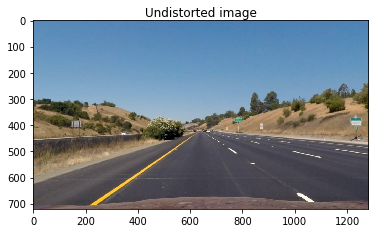

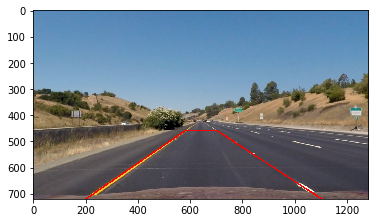

In [6]:
# define source and destination points for perspective transform

# read and undistort image
wrp_src_img = mpimg.imread('test_images/straight_lines1.jpg')
wrp_img_size = (wrp_src_img.shape[1], wrp_src_img.shape[0])
undist_wrp_img = cv2.undistort(wrp_src_img, mtx, dist_coeff)

# show undistorted image to determine source points
# %matplotlib notebook # enables zoom and mouse coordinates
plt.figure()
plt.imshow(undist_wrp_img)
plt.title('Undistorted image')

# source points manually determined from test image "straight_lines1.jpg"
src_pts = np.array([[580, 460], [700, 460], [1100, wrp_img_size[1]], [200, wrp_img_size[1]]], 
                   np.float32).reshape((4, 1, 2))
# src_pts = np.array([[560, 475], [725, 475], [1100, img_size[1]], [200, img_size[1]]], 
#                    np.float32).reshape((4, 1, 2))
# src_pts = np.array([[595, 450], [685, 450], [1100, img_size[1]], [200, img_size[1]]], 
#                    np.float32).reshape((4, 1, 2))

# destination points for perspective transformation
lane_dist = 700 # in pixels
mid_pnt = wrp_img_size[0]//2
dst_pts = np.array([[mid_pnt - lane_dist/2, 0], [mid_pnt + lane_dist/2, 0], 
                    [mid_pnt + lane_dist/2, wrp_img_size[1]], [mid_pnt - lane_dist/2, wrp_img_size[1]]], 
                   np.float32).reshape((4, 1, 2))

# show undistorted image with source area
undist_wrp_img_src = np.copy(undist_wrp_img)
draw_lines_from_points(undist_wrp_img_src, src_pts)
plot(undist_wrp_img_src)

In [7]:
# compute perspective transform matrix and inverse matrix
warp_mtx, warp_inv_mtx = get_warp_mat(src_pts, dst_pts)
print('transformation matrix:\n', warp_mtx)
print('inverse transformation matrix:\n', warp_inv_mtx)

transformation matrix:
 [[ -5.55555556e-01  -1.50244200e+00   9.85726496e+02]
 [  0.00000000e+00  -1.97802198e+00   9.09890110e+02]
 [  2.93511629e-19  -2.38095238e-03   1.00000000e+00]]
inverse transformation matrix:
 [[  1.71428571e-01  -7.68518519e-01   5.30285714e+02]
 [  4.58932415e-17  -5.05555556e-01   4.60000000e+02]
 [  2.24588775e-19  -1.20370370e-03   1.00000000e+00]]


In [8]:
# define perspective transform function
def warp(img):
    warped_img = cv2.warpPerspective(img, warp_mtx, wrp_img_size, flags=cv2.INTER_LINEAR)
    return warped_img

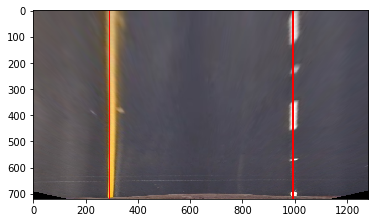

In [9]:
# perform perspective transformation
warped_img = cv2.warpPerspective(undist_wrp_img, warp_mtx, wrp_img_size, flags=cv2.INTER_LINEAR)

# draw lines on warped image and plot
warped_img_roi = np.copy(warped_img)
draw_lines_from_points(warped_img_roi, dst_pts)
plot(warped_img_roi)

#### Criteria: Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

##### gradient (function sobel_thresh)

>"In our last example, output datatype is cv2.CV_8U or np.uint8. But there is a slight problem with that. Black-to-White transition is taken as Positive slope (it has a positive value) while White-to-Black transition is taken as a Negative slope (It has negative value). So when you convert data to np.uint8, all negative slopes are made zero. In simple words, you miss that edge.

>If you want to detect both edges, better option is to keep the output datatype to some higher forms, like cv2.CV_16S, cv2.CV_64F etc, take its absolute value and then convert back to cv2.CV_8U. Below code demonstrates this procedure for a horizontal Sobel filter and difference in results."

https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_gradients/py_gradients.html

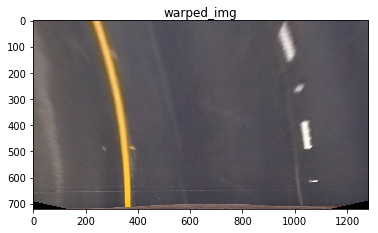

In [10]:
# read image and get size
# src_img = mpimg.imread('test_images/straight_lines1.jpg')
src_img = mpimg.imread('test_images/test2.jpg')
img_size = (src_img.shape[1], src_img.shape[0])

# undistort and warp
undist_img = undistort(src_img)
warped_img = warp(undist_img)

plt.imshow(warped_img)
plt.title('warped_img')

Grdient thresholds

In [11]:
# gradient thresholds

# define gradient threshold function
def grad_thresh(img, orient='x', 
                kernel = 3, thresh=(0, 255)):
    """Creates thresholded binary image based on directional 
    gradient"""
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # take derivative in 'orient' direction
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    else:
        print('only x and y are accepted as 2nd argument')
        return None
    # calculate absolute value and scale to 8-bit
    abs_sobel = np.abs(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel/np.max(abs_sobel))
    # create binary image
    grad_bin = np.zeros_like(scaled_sobel)
    grad_bin[(scaled_sobel >= thresh[0]) & 
                (scaled_sobel <= thresh[1])] = 1
    # return binary image
    return grad_bin

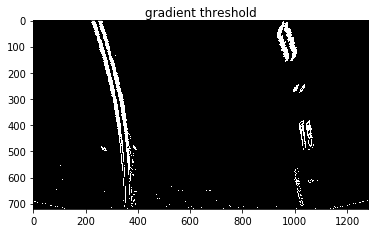

In [12]:
# create and plot gradient threshold image
grad_bin_img = grad_thresh(warped_img, 'x', 
                          kernel = 3, thresh = (20, 80))
plt.imshow(grad_bin_img, cmap = 'gray')
plt.title('gradient threshold')

In [13]:
# define gradient magnitude function
def grad_mag_thresh(img, kernel = 3, thresh = (0, 255)):
    # convert to grayscale    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # apply sobel in both x and y direction
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    # calculate magnitude
    abs_sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
    # scale to 8-bit and convert to type uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # create binary magnitude image
    grad_mag_bin = np.zeros_like(scaled_sobel)
    grad_mag_bin[(scaled_sobel >= thresh[0]) & 
            (scaled_sobel <= thresh[1])] = 1
    # return binary image
    return grad_mag_bin

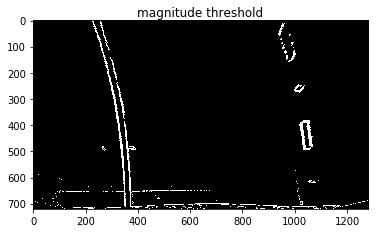

In [14]:
# create and plot gradient magnitude threshold image
grad_mag_bin_img = grad_mag_thresh(warped_img, kernel = 3, thresh = (20, 100))
plt.imshow(grad_mag_bin_img, cmap = 'gray')
plt.title('magnitude threshold')

In [15]:
# define gradient direction threshold function
def grad_dir_thresh(image, kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # apply sobel
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    # calculate absolute values of sobelx and sobely
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    # calculate gradient direction
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # apply threshold
    grad_dir_bin = np.zeros_like(gray)
    grad_dir_bin[(grad_dir >= thresh[0]) & 
            (grad_dir <= thresh[1])] = 1
    
    return grad_dir_bin

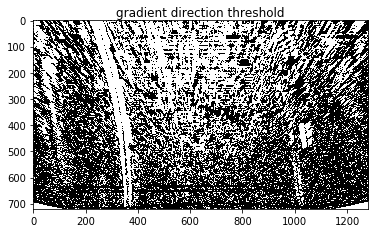

In [16]:
# create and plot gradient direction threshold image
grad_dir_bin_img = grad_dir_thresh(warped_img, 
                         kernel = 7, thresh = (0, 0.5))
plt.imshow(grad_dir_bin_img, cmap = 'gray')
plt.title('gradient direction threshold')

Color thresholds

In [17]:
# color thresholds

# define color threshold function
def color_s_thresh(img, thresh = (0, 255)):
    # convert image to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    color_s_bin = np.zeros_like(hls[:,:,2])
    color_s_bin[(hls[:,:,2] > thresh[0]) & 
                  (hls[:,:,2] <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return color_s_bin

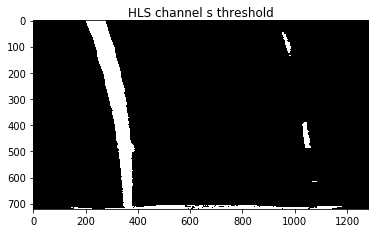

In [18]:
# create and plot color threshold image
bin_img = color_s_thresh(warped_img, thresh = (30, 255)) # good: 120, 255
# color_bin_img = color_s_thresh(warped_img, thresh = (240, 250)) # bad
plt.imshow(bin_img, cmap = 'gray')
plt.title('HLS channel s threshold')

#### Criteria: Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?



In [19]:
# functions called in find_lane_pixels() function

def split_hist(img):
    # create histogramm from bottom half of the image
#     import pdb; pdb.set_trace()
    hist = np.sum(img[img.shape[0]//2:, :], axis = 0)
    # find midpoint
    mid_pnt = np.int(hist.shape[0]//2)
    # find left and right windows start positions based on peaks in histogram
    left_x_start = np.argmax(hist[:mid_pnt])
    right_x_start = np.argmax(hist[mid_pnt:]) + mid_pnt
    # handle the situation when no right line is detected
    if (right_x_start == mid_pnt) & (left_x_start != 0) & (left_x_start + 700 < img.shape[1]):
        # a distance of 700 pixels between the two lanes is assumed here
        right_x_start = left_x_start + 700
    # handle the situation when no left line is detected
    elif (left_x_start == 0) & (right_x_start != mid_pnt) & (right_x_start - 700 > 0):
        # a distance of 700 pixels is assumed here as well
        left_x_start = right_x_start - 700
    # when no lines are detected, the quarter of the image seems a good guess for searching
    elif (left_x_start == 0) & (right_x_start == mid_pnt):
        left_x_start = img.shape[1]//4
        right_x_start = img.shape[1] - img.shape[1]//4

    ###
    ### TODO: handle all cases! ###
    ### color_bin_img = color_s_thresh(warped_img, thresh = (240, 250)) works good with image
    ### src_img = mpimg.imread('test_images/test1.jpg') -> no right lane detected
      
    return (left_x_start, right_x_start)

def nonzero_xy(img):
    # find x and y positions of all nonzero pixels
    nonzero = img.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    return (nonzero_x, nonzero_y)

# functions called inside for loop
def win_bound(img, win, margin, win_h, left_x_current, right_x_current):
        # determine window y boundaries
        win_y_low = img.shape[0] - (win + 1) * win_h
        win_y_high = img.shape[0] - win * win_h
        win_y = np.array([win_y_low, win_y_high])
        # determine window x boundaries
        win_x_left_low = left_x_current - margin
        win_x_left_high = left_x_current + margin
        win_x_left = np.array([win_x_left_low, win_x_left_high])
        win_x_right_low = right_x_current - margin
        win_x_right_high = right_x_current + margin
        win_x_right = np.array([win_x_right_low, win_x_right_high])
        return (win_x_left, win_x_right, win_y)
    
def draw_win(img, win_x_left, win_x_right, win_y):
    # draw windows on image
    cv2.rectangle(img, (win_x_left[0], win_y[0]), (win_x_left[1], win_y[1]), (0, 255, 0), 2)
    cv2.rectangle(img, (win_x_right[0], win_y[0]), (win_x_right[1], win_y[1]), (0, 255, 0), 2)
    return None

def find_nonzero_inds(nonzero_x, nonzero_y, win_y, win_x_left, win_x_right):
    # find nonzero pixels in x and y within current window
    good_left_inds = ((nonzero_y >= win_y[0]) & (nonzero_y < win_y[1]) & 
                              (nonzero_x >= win_x_left[0]) & (nonzero_x < win_x_left[1])).nonzero()[0]
    good_right_inds = ((nonzero_y >= win_y[0]) & (nonzero_y < win_y[1]) & 
                              (nonzero_x >= win_x_right[0]) & (nonzero_x < win_x_right[1])).nonzero()[0]
    return (good_left_inds, good_right_inds)

In [20]:
# number of sliding windows
n_win = 9
# windows width (+/-margin)
margin = 100
# min number of pixels to recenter window
min_pix = 50
# set window height
win_h = np.int(img.shape[0]//n_win)

In [21]:
def find_lane_pix_slid_win(img, show_win=False):
    
    # create 3 channel image
    out_img = np.dstack((img, img, img))*255
    
    # split histogram for the two lines
    leftx_start, rightx_start = split_hist(img)
    # find x and y position of all nonzero pixels in the image
    nonzero_x, nonzero_y = nonzero_xy(img)
    
    # initialize current window positions with start values from histogram
    leftx_current = leftx_start
    rightx_current = rightx_start
    
    # initialization of empty lists for lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # loop through all windows
    for win in range(n_win):
        
        # determine window boundaries
        win_x_left, win_x_right, win_y = win_bound(img, win, margin, win_h, leftx_current, rightx_current)
                
        if show_win==True:
            # draw current window
            draw_win(out_img, win_x_left, win_x_right, win_y)
        
        # find nonzero indices within the window
        good_left_inds, good_right_inds = find_nonzero_inds(nonzero_x, nonzero_y, 
                                                            win_y, win_x_left, win_x_right)
        
        # append the indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # if pixels in window > minpix pixels, recenter next window on their mean position
        if np.count_nonzero(good_left_inds) > min_pix:
            leftx_current = np.uint16(np.mean(nonzero_x[good_left_inds]))
        if np.count_nonzero(good_right_inds) > min_pix:
            rightx_current = np.uint16(np.mean(nonzero_x[good_right_inds]))
        
    try:
        # create one array of indices out of the list of lists
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
        
    # Extract left and right line pixel positions
    leftx = nonzero_x[left_lane_inds]
    lefty = nonzero_y[left_lane_inds] 
    rightx = nonzero_x[right_lane_inds]
    righty = nonzero_y[right_lane_inds]
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    return (leftx, lefty, rightx, righty, out_img)
#     return (leftx, lefty, rightx, righty, out_img, leftx_start, rightx_start)

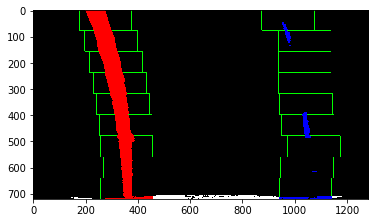

In [22]:
leftx, lefty, rightx, righty, lane_pix_img = find_lane_pix_slid_win(bin_img, True)

plt.imshow(lane_pix_img)

In [ ]:
def fit_poly(img):
    if Left.detected == False:
        leftx, lefty, rightx, righty, lane_pix_img = find_lane_pix_slid_win(img, False)
    else:
        leftx, lefty, rightx, righty, lane_pix_img = find_lane_pix_prev_poly(img)
        
    # Fit a second order polynomial to each using `np.polyfit`
    if (lefty.size != 0) & (leftx.size != 0):
        left_fit = np.polyfit(lefty, leftx, 2)
#     else: # handle if no pixels have been detected for fitting
#         left_fit = np.polyfit(np.array([img.shape[0], img.shape[0]//2, 0]), 
#                            np.ones(3)*leftx_start, 2)

    if (righty.size != 0) & (rightx.size != 0):
        right_fit = np.polyfit(righty, rightx, 2)
#     else: # handle if no pixels have been detected for fitting
#         right_fit = np.polyfit(np.array([img.shape[0], img.shape[0]//2, 0]), 
#                            np.ones(3)*rightx_start, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
#     lane_fit_img = np.dstack((lane_pix_img, lane_pix_img, lane_pix_img))*255
    
    lane_fit_img = np.dstack((img, img, img))*255
    
    ## Visualization ##
    # Colors in the left and right lane fits
    lane_fit_img[ploty.astype(int), left_fitx.astype(int)] = [255, 0, 0]
    lane_fit_img[ploty.astype(int), right_fitx.astype(int)] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')

    return (left_fit, right_fit, ploty, left_fitx, right_fitx, lane_fit_img)


In [ ]:
left_fit, right_fit, ploty, left_fitx, right_fitx, lane_fit_img = fit_poly(bin_img)

plt.imshow(lane_fit_img)

In [23]:
# # image to display lane line fits on
# out_img = np.dstack((img, img, img))

def find_lane_pix_prev_poly(img):
    
    # create 3 channel image
    out_img = np.dstack((img, img, img))*255
    
    nonzero_y = np.array(img.nonzero()[0])
    nonzero_x = np.array(img.nonzero()[1])
    
    left_lane_inds = ((nonzero_x > 
                    (left_fit[0]*(nonzero_y**2) + left_fit[1]*nonzero_y + left_fit[2] - margin)) 
                    & (nonzero_x < 
                    (left_fit[0]*(nonzero_y**2) + left_fit[1]*nonzero_y + left_fit[2] + margin)))
    right_lane_inds = ((nonzero_x > 
                    (right_fit[0]*(nonzero_y**2) + right_fit[1]*nonzero_y + right_fit[2] - margin)) 
                    & (nonzero_x < 
                    (right_fit[0]*(nonzero_y**2) + right_fit[1]*nonzero_y + right_fit[2] + margin)))
    
    leftx = nonzero_x[left_lane_inds]
    lefty = nonzero_y[left_lane_inds] 
    rightx = nonzero_x[right_lane_inds]
    righty = nonzero_y[right_lane_inds]

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
#     if show==True:
#         src_img = np.copy(img)
#         lane_img = np.zeros_like(src_img)
#         lane_img[left_y, left_x] = [255, 0, 0]
#         lane_img[right_y, right_y] = [0, 0, 255]
#         cv2.addWeighted(src_img, 1, lane_img, 1, 0)
    
    return (leftx, lefty, rightx, righty, out_img)

In [24]:
leftx, lefty, rightx, righty, out_imt = find_lane_pix_prev_poly(bin_img)

NameError: name 'left_fit' is not defined

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None 

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        n_prev_lanes = 10
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque(maxlen=n_prev_lanes) 
        #average x values of the fitted line over the last n iterations
        self.bestx = deque(maxlen=n_prev_lanes)     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = deque(maxlen=n_prev_lanes)
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None 

In [ ]:
Left = Line()
Right = Line()

In [ ]:
# conversion from pixel space to meters
ym_per_pix = 21/720
xm_per_pix = 3.7/900

#### Criteria: Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

$R_{curve} = \frac{(1 + (2 Ay + B)²)^{3/2}}{\lvert2A\rvert}$

In [ ]:
def curve_radius(x_vals, y_vals):
    
    real_fit = np.polyfit(y_vals*ym_per_pix, x_vals*xm_per_pix, 2)
    
    num = (1 + (2*real_fit[0]*np.max(y_vals)*ym_per_pix + real_fit[1])**2)**(3/2)
    denum = np.abs(2*real_fit[0])
    radius = num/denum
    
    return radius

def curve_radius_old(y_eval, left_fit, right_fit):
    
#     real_fit = np.polyfit()
    
    num_left = (1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**(3/2)
    denum_left = np.abs(2*left_fit[0])
    radius_left = num_left/denum_left
    
    num_right = (1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**(3/2)
    denum_right = np.abs(2*right_fit[0])
    radius_right = num_right/denum_right
    
    return (radius_left, radius_right)

# def get_offset():
    
    
    
#     return offset

In [ ]:
curverat_old = curve_radius_old(undist_img.shape[0], left_fit, right_fit)
curverat_real_left = curve_radius(leftx, lefty)
curverat_real_right = curve_radius(rightx, righty)
print(curverat_old)
print(curverat_real_left, curverat_real_right)

#### Criteria: Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

In [ ]:
# create black image to visualize detected pixels, windows and lane lines
# def show_detected_lane_pixels(left_x, left_y, right_x, right_y, img_size):
def show_detected_lane_pixels(left_x, left_y, right_x, right_y):
    blk_img = np.zeros_like(color_bin_img)
#     blk_img = np.zeros(img_size)
    lane_img_bird = np.dstack((blk_img, blk_img, blk_img))
    lane_img_bird[left_y, left_x] = [255, 0, 0]
    lane_img_bird[right_y, right_x] = [0, 0, 255]
#     plt.imshow(lane_img_bird)
    return lane_img_bird

def plot_lanes_on_image(left_x, left_y, right_x, right_y, undist_img):
    lane_img_bird = show_detected_lane_pixels(left_x, left_y, right_x, right_y)
    unwarped_lane_img = cv2.warpPerspective(lane_img_bird, warp_inv_mtx, img_size, flags = cv2.INTER_LINEAR)
    plt.figure(); plt.imshow(unwarped_lane_img)
    weighted_img = cv2.addWeighted(undist_img, 1, unwarped_lane_img, 0.3, 0)
    plt.figure(); plt.imshow(weighted_img)
    return 

weighted_img = plot_lanes_on_image(left_x, left_y, right_x, right_y, undist_img)
# plt.imshow(weighted_img)

undist_img_cp = np.copy(undist_img)

def plot_lane_area(left_fitx, right_fitx, ploty, undist_img):
    warped_lane_img = np.zeros_like(undist_img)
#     lane_img_bird[10:lane_img_bird.shape[0], 100:lane_img_bird.shape[1]] = [0, 255, 0]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    line_pts = np.hstack((left_line, right_line))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(warped_lane_img, np.int_([line_pts]), (0,255, 0))
    
    unwarped_lane_img = cv2.warpPerspective(warped_lane_img, warp_inv_mtx, img_size, flags = cv2.INTER_LINEAR)
    
    result = cv2.addWeighted(undist_img, 1, unwarped_lane_img, 0.3, 0)
#     plt.imshow(unwarped_lane_img)
    return result

plotted_back = plot_lane_area(left_fitx, right_fitx, ploty, undist_img_cp)
plt.imshow(plotted_back)

In [ ]:

unwarped_lane_img = cv2.warpPerspective(undist_img, warp_mtx, img_size, 
                   flags = cv2.INTER_LINEAR)

In [ ]:

# read image and get size
# src_img = mpimg.imread('test_images/straight_lines1.jpg')
src_img = mpimg.imread('test_images/test1.jpg')
img_size = (src_img.shape[1], src_img.shape[0])

In [ ]:
def pipeline():
    
    undist_img = cv2.undistort(src_img, mtx, dist_coeff)
    warped_img = cv2.warpPerspective(undist_img, warp_mtx, img_size, flags = cv2.INTER_LINEAR)
    
    bin_warped_img = color_s_thresh(warped_img, thresh = (120, 255))
    
    left_x, left_y, right_x, right_y, lane_fit_img, left_x_start, right_x_start = find_lane_pix_slid_win(bin_warped_img)
    
#     left_fit, right_fit, lane_fit_img = fit_poly(img_size) #, left_x, left_y, right_x, right_y)
    
    left_radius, right_radius = curve_radius(img_size, left_fit, right_fit)
    
    unwarped_img = cv2.warpPerspective(lane_fit_img, warp_inv_mtx, img_size, flags = cv2.INTER_LINEAR)
    
    plt.imshow(unwarped_img)
    
    return None

In [ ]:
pipeline()

In [ ]:
# test_list = [['abc','def'], [1,2]]

# print(test_list)
# print(type(test_list))
# print(np.shape(test_list))
# print('\n')
# test_list = np.concatenate(test_list)
# print(test_list)
# print(type(test_list))
# print(np.shape(test_list))

In [ ]:
def pipeline(src_img):
    # undistort image    
    
    undist_img = calib.undistort(src_img)
#     plot_func(img); plot_func(undist)

#     warped_img = calib.warp(undist)
    warp_mtx = cv2.getPerspectiveTransform(src_pts, )

    plot(undist_img)
    plot(warped_img)
    
    #     grad_thresh(undist)

In [ ]:
pipe_out = pipeline(test_img)

# backup

In [ ]:
### todo: class and functions descriptions
class Calibration:
    
    def __init__(self, cam_mtx, dist_coeff, src_pts, dst_pts):
        self.cam_mtx = cam_mtx
        self.dist_coeff = dist_coeff
        self.src_pts = src_pts
        self.dst_pts = dst_pts
        self.warp_mtx = cv2.get_PerspectiveTransform(scr_pts, dst_pts)
        
    def undistort(self, dist_img):
        undist_img = cv2.undistort(dist_img, self.cam_mtx, 
                                   self.dist_coeff, None, 
                                   self.cam_mtx)
        return undist_img
    
    def warp(self, img):
        img_size = (img.shape[1], img.shape[0])
        warped_img = cv2.warpPerspective(img, self.warp_mtx, 
                                         img_size, 
                                         flags = cv2.INTER_LINEAR)
        return warped_img

In [ ]:
# unwarped_img = np.copy(undist_img)
raw_img = mpimg.imread('test_images/test6.jpg')
undist_img = calib.undistort(raw_img)
# raw_img = mpimg.imread('test_images/test1.jpg')
# undist_img = calib.undistort(raw_img)

warp_mtx = cv2.getPerspectiveTransform(src_pts, dst_pts)
warped_img = cv2.warpPerspective(undist_img, warp_mtx, 
                                 img_size, flags=cv2.INTER_LINEAR)

plt.figure()
plt.imshow(undist_img)
line_img1 = draw_lines_from_points(undist_img, src_pts)
plt.figure()
plt.imshow(undist_img)

plt.figure()
plt.imshow(warped_img)
line_img2 = draw_lines_from_points(warped_img, dst_pts)
plt.figure()
plt.imshow(warped_img)
